In [ ]:
!pip install langchain
!pip install langchain-community
!pip install sentence-transformers      # embedder
!pip install faiss-cpu                  # vector store

!pip install transformers
!pip install bitsandbytes               # model quantization
!pip install torch
!pip install huggingface-hub -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.8 MB/s eta 0:00:00


In [ ]:
pip install "accelerate>=0.26.0"

In [ ]:
pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.9 MB/s eta 0:00:00


In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Dataset construction

In [ ]:
airbnb1 = pd.read_csv("airbnb1.csv")
airbnb2 = pd.read_csv("airbnb2.csv")
airbnb3 = pd.read_csv("airbnb3.csv")
airbnb4 = pd.read_csv("airbnb4.csv")
airbnb5 = pd.read_csv("airbnb5.csv")
airbnb6 = pd.read_csv("airbnb6.csv")

In [ ]:
#Concatenating csv files in a final dataset
df = pd.concat([airbnb1, airbnb2, airbnb3, airbnb4, airbnb5, airbnb6], ignore_index = True)

#Selecting useful information and rename columns
df = df[['id','language','localizedText','localizedReview/localizedDate','reviewer/firstName', 'reviewer/id','startUrl']]
df = df.rename(columns={'localizedText': 'ItalianReview', 'reviewer/firstName':'reviewer_name','reviewer/id':'reviewer_id','startUrl':'url',
                        'localizedReview/localizedDate':'Date'})

In [ ]:
#English reviews to be joined in the original dataset
english_reviews1= pd.read_csv("english_reviews1.csv")
english_reviews2= pd.read_csv("english_reviews2.csv")
english_reviews3= pd.read_csv("english_reviews3.csv")

english_data = pd.concat([english_reviews1, english_reviews2, english_reviews3], ignore_index = True)
english_data = english_data.rename(columns={'localizedText':'EnglishReview'})

In [ ]:
#Combining data
data = pd.merge(df, english_data, on='id')

In [ ]:
print(f"The dataset contains {sum(data.duplicated(subset=['EnglishReview', 'reviewer_name','reviewer_id']))} duplicates")

#Dropping duplicates
data = data.drop_duplicates(subset= ['EnglishReview', 'reviewer_name','reviewer_id'])

print(f"The dataset after dropping contains {sum(data.duplicated(subset=['EnglishReview', 'reviewer_name','reviewer_id']))} duplicates")

The dataset contains 2191 duplicates
The dataset after dropping contains 0 duplicates


In [ ]:
#Check for NA values in reviews
print(data['EnglishReview'].isnull().sum())

0


In [ ]:
#Filling NA values for Dates and Years on AirBnB
data['Date'] = data['Date'].fillna('')

<ipython-input-10-0cb0bf5a2c92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data['Date'].fillna('')


In [ ]:
def transform_url(url: str) -> str:
    base = url.split('?')[0]  # remove everything after '?'
    return base.replace("www.airbnb.it", "www.airbnb.com")

data["url"] = data["url"].apply(transform_url)

<ipython-input-11-f9f9c783b252>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["url"] = data["url"].apply(transform_url)


In [ ]:
data.head()

,id,language,ItalianReview,Date,reviewer_name,reviewer_id,url,EnglishReview
0,1302092149169448912,it,"Giordano è stato molto gentile sin da subito, ...",,Francesca,266705689,https://www.airbnb.com/rooms/42367432,"Giordano was very kind right away, he took car..."
1,1298493632099626284,it,Giordano è stato un host spettacolare e molto ...,,Sarah,77259330,https://www.airbnb.com/rooms/42367432,Giordano was a spectacular and very welcoming ...
2,1281090206418176674,en,Bellissimo appartamento in posizione molto tra...,novembre 2024,Harry,52379900,https://www.airbnb.com/rooms/42367432,A beautiful apartment at a very quiet location...
3,1273870425283785878,it,molto spesso viaggio e ho visto moltissimi all...,,Petrila,348584200,https://www.airbnb.com/rooms/42367432,very often I travel and I have seen many accom...
4,1263642124858487365,sk,Le esperienze con Giordano sono state al di so...,ottobre 2024,Oldrich,259968673,https://www.airbnb.com/rooms/42367432,The experiences with Giordano were above my ex...


In [ ]:
add_info1 = pd.read_csv("details1.csv")
add_info2 = pd.read_csv("details2.csv")

add_info1 = add_info1.iloc[:35,:]
add_info2 = add_info2.iloc[:81,:]


add_info = pd.concat([add_info1, add_info2], ignore_index = True)
add_info = add_info.drop_duplicates()
add_info.rename(columns={'address':'city'}, inplace=True)

In [ ]:
add_info = add_info.loc[:,['name','additionalHouseRules','city','bathroomLabel','bedroomLabel','guestControls/allowsChildren','guestControls/allowsEvents',
                           'guestControls/allowsInfants','guestControls/allowsPets','guestControls/allowsSmoking','guestControls/personCapacity',
                           'guestControls/structuredHouseRules/1', 'guestControls/structuredHouseRules/0',
                           'guestControls/structuredHouseRules/2','listingExpectations/0/title','listingExpectations/1/title','isHostedBySuperhost',
                           'roomType','url']]
add_info.rename(columns={'guestControls/allowsChildren': 'allowChildren', 'guestControls/allowsEvents':'allowsEvents','guestControls/allowsInfants':'allowsInfant',
                        'guestControls/allowsPets':'allowsPets','guestControls/allowsSmoking':'allowsSmoking','guestControls/personCapacity':'personCapacity',
                         'additionalHouseRules':'HouseRules1','guestControls/structuredHouseRules/0':'HouseRules2','guestControls/structuredHouseRules/1':'HouseRules3',
                         'guestControls/structuredHouseRules/2':'HouseRules4','listingExpectations/0/title':'HouseRules5',
                         'listingExpectations/1/title':'HouseRules6'}, inplace=True)

In [ ]:
from deep_translator import GoogleTranslator

# Initialize the translator
translator = GoogleTranslator(source='auto', target='en')
# List of columns to translate
columns_to_translate = ['bathroomLabel', 'bedroomLabel','city','roomType']

# Apply the translation
for col in columns_to_translate:
    add_info[col] = add_info[col].apply(lambda x: translator.translate(x))

In [ ]:
add_info.head()

,name,HouseRules1,city,bathroomLabel,bedroomLabel,allowChildren,allowsEvents,allowsInfant,allowsPets,allowsSmoking,personCapacity,HouseRules3,HouseRules2,HouseRules4,HouseRules5,HouseRules6,isHostedBySuperhost,roomType,url
0,Camera Tua® J5 •Camera con bagno •Centro/Ospedali,NaN,"Padua, Veneto, Italy",1 private bathroom,1 bedroom,False,False,False,True,False,2,L'orario di check-in è previsto a partire dall...,Non è consentito fumare e organizzare feste o ...,NaN,Sono presenti dispositivi di sorveglianza o di...,NaN,True,Private room in apartment,https://www.airbnb.com/rooms/946395299870148714
1,Casa Cleopatra,La casa viene rispettata come fosse la propria...,"Padua, Veneto, Italy",1 bathroom,1 bedroom,True,False,True,True,False,4,L'orario di check-in è previsto a partire dall...,Non è consentito fumare e organizzare feste o ...,NaN,Nell'alloggio ci sono animali domestici,Limitazioni di servizi,True,Entire accommodation: apartment,https://www.airbnb.com/rooms/33852057
2,Stanza Privata da zia Lella - Prato della Valle,Chiudere sempre le porte della camera e del ba...,"Padua, Veneto, Italy",1 shared bathroom,1 bedroom,False,False,False,False,True,1,Vietato organizzare feste/eventi,Non sicuro o adatto ai bambini (da 0 a 12 anni...,L'orario di check-in è previsto a partire dall...,È necessario salire delle scale,Alcuni spazi sono in comune,True,Private room in rented accommodation,https://www.airbnb.com/rooms/30282866
3,Est Padova,Bisogna fare silenzio dopo le 22'00.,"Padua, Veneto, Italy",1 shared bathroom,1 bedroom,True,False,True,False,False,2,Non è consentito fumare e organizzare feste o ...,Animali non ammessi,L'orario di check-in è tra le 18:00 e le 21:00...,Parcheggio non disponibile nell'alloggio,È necessario salire delle scale,True,Private room in apartment,https://www.airbnb.com/rooms/36774397
4,Ca' Jolie\nGrazioso monolocale,E' consentito fumare solo sul terrazzo e nel g...,"Schools, Veneto, Italy",1 bathroom,1 bedroom,False,False,False,False,False,2,Non è consentito fumare e organizzare feste o ...,Non sicuro o adatto ai bambini (da 0 a 12 anni...,L'orario di check-in è tra le 15:00 e le 20:00...,È necessario salire delle scale,Alcuni spazi sono in comune,True,Entire accommodation: accommodation for rent,https://www.airbnb.com/rooms/973249970451204824


In [ ]:
def create_info_dataset(data):
  final_data = pd.DataFrame()
  house_rules_columns = [col for col in data.columns if col.startswith('HouseRules')]
  for col in house_rules_columns:
    data_copy = data.copy()
    data_copy.rename(columns={col: 'Documents'}, inplace=True)
    data_copy.drop(columns=[col for col in data_copy.columns if col.startswith('HouseRules')], inplace=True)
    final_data = pd.concat([final_data,data_copy], ignore_index=True)
  final_data.dropna(subset=['Documents'], inplace=True)

  translator = GoogleTranslator(source='auto', target='en')

  # Translate the 'Text' column
  final_data['Documents'] = final_data['Documents'].apply(lambda x: translator.translate(x))

  return final_data

In [ ]:
add_info_final = create_info_dataset(add_info)

In [ ]:
info_accomodation = add_info.copy()
info_accomodation = info_accomodation.drop(columns=['HouseRules1','HouseRules2','HouseRules3','HouseRules4','HouseRules5','HouseRules6'])

In [ ]:
dataset = pd.merge(data, info_accomodation, on="url")
dataset.drop(columns=["id","language","ItalianReview","reviewer_name","reviewer_id","Date"], inplace=True)
dataset.rename(columns={'EnglishReview':'Documents'}, inplace=True)

In [ ]:
final_data = pd.concat([dataset, add_info_final])
final_data

,url,Documents,name,city,bathroomLabel,bedroomLabel,allowChildren,allowsEvents,allowsInfant,allowsPets,allowsSmoking,personCapacity,isHostedBySuperhost,roomType
0,https://www.airbnb.com/rooms/42367432,"Giordano was very kind right away, he took car...",Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation: accommodation for rent
1,https://www.airbnb.com/rooms/42367432,Giordano was a spectacular and very welcoming ...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation: accommodation for rent
2,https://www.airbnb.com/rooms/42367432,A beautiful apartment at a very quiet location...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation: accommodation for rent
3,https://www.airbnb.com/rooms/42367432,very often I travel and I have seen many accom...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation: accommodation for rent
4,https://www.airbnb.com/rooms/42367432,The experiences with Giordano were above my ex...,Accogliente appartamento vicino a Padova,"Casalserugo, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,4,True,Entire accommodation: accommodation for rent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
662,https://www.airbnb.com/rooms/26873338,It is necessary to climb some stairs,Suite degli ospiti a Padova,"Padua, Veneto, Italy",1 bathroom,1 bedroom,True,False,True,False,False,3,False,Entire accommodation: guest suite
666,https://www.airbnb.com/rooms/38340832,Are there any surveillance or recording device...,Camera Tua® C5•Camera con bagno • Centro/Ospedali,"Padua, Veneto, Italy",1 private bathroom,1 bedroom,True,False,False,True,False,2,True,Private room in apartment
669,https://www.airbnb.com/rooms/24283977,There might be some noise,Peaceful Portello home,"Padua, Veneto, Italy",1 bathroom,2 bedrooms,True,False,True,False,False,5,True,Entire accommodation: house
670,https://www.airbnb.com/rooms/598902756319251215,There might be some noise,Monolocale soppalcato Portello,"Padua, Veneto, Italy",1 bathroom,1 bedroom,False,False,False,True,False,2,False,Entire accommodation: apartment


In [ ]:
sum(final_data['Documents'].isna())

0

In [ ]:
from google.colab import files

# Save DataFrame to a CSV file
final_data.to_csv('final_data.csv', index=False)

# Download the file
files.download('final_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Exploration

### Word frequency analysis

In [ ]:
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

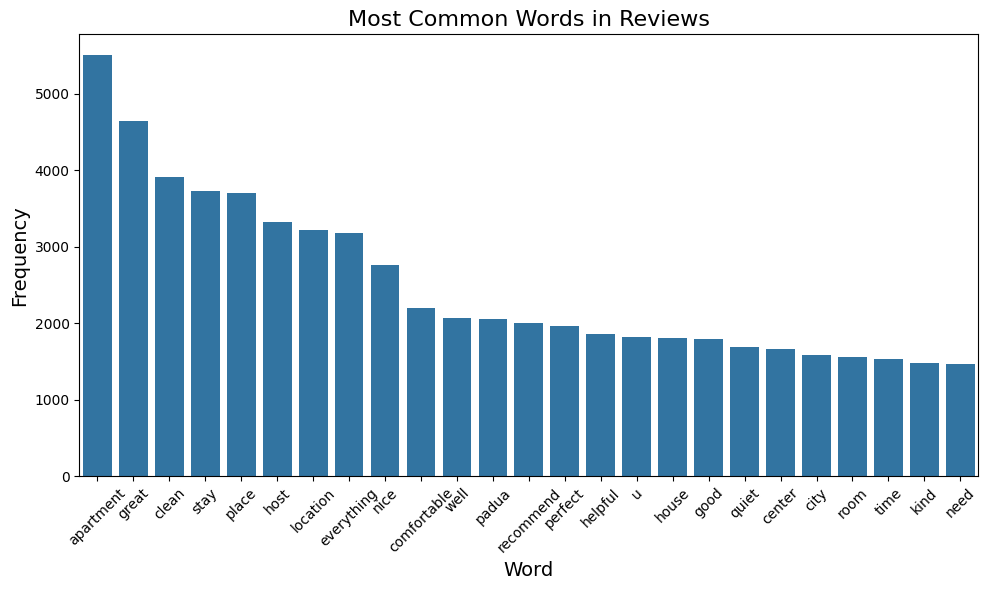

In [ ]:
#Plotting the most common words
processed_reviews = pd.DataFrame({'review_tokens': final_data['Documents'].apply(preprocess_text)})
all_tokens = [token for review in processed_reviews['review_tokens'] for token in review]
word_freq = Counter(all_tokens)
common_words = word_freq.most_common(25)

word_freq_df = pd.DataFrame(common_words, columns=['word', 'frequency'])
# plt.figure(figsize=(10, 6))
# sns.barplot(x='frequency', y='word', data=word_freq_df)
# plt.title('Most Common Words')
# plt.show()

# Plot customization
plt.figure(figsize=(10, 6))
sns.barplot(
    x='word',          # Words on the x-axis
    y='frequency',     # Frequency on the y-axis
    data=word_freq_df
)

# Adding labels and title
plt.title('Most Common Words in Reviews', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

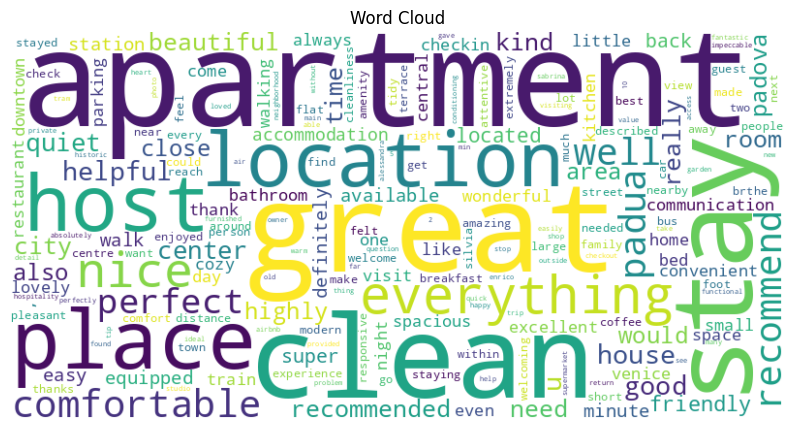

In [ ]:
# Word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

### How many words per review

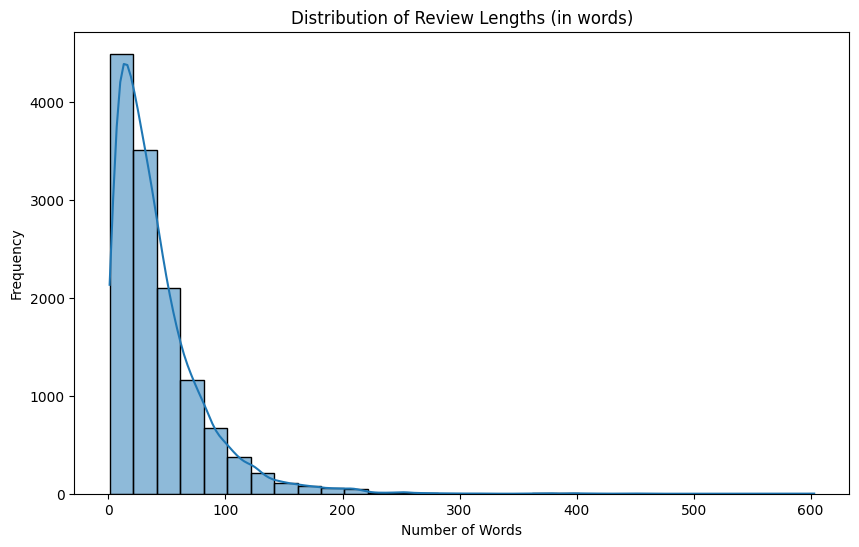

In [ ]:
processed_reviews['words_count'] = final_data['Documents'].apply(lambda x: len(word_tokenize(x)))
plt.figure(figsize=(10, 6))
sns.histplot(processed_reviews['words_count'], binwidth=20, kde=True)
plt.title('Distribution of Review Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### How many reviews for accomodation

In [ ]:
grouped = data.groupby('url').size()

# Calculate statistics
average_reviews = grouped.mean()
min_reviews = grouped.min()
max_reviews = grouped.max()

# Display the results
print(f"Average number of reviews per accommodation: {average_reviews}")
print(f"Minimum number of reviews: {min_reviews}")
print(f"Maximum number of reviews: {max_reviews}")

Average number of reviews per accommodation: 110.65178571428571
Minimum number of reviews: 1
Maximum number of reviews: 384


### Zipf's and Heap's Law verifications

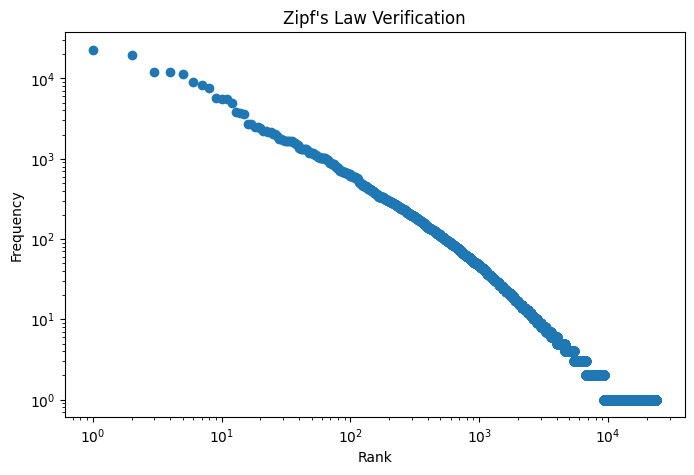

In [ ]:
# Tokenize all reviews
all_words = ' '.join(data['EnglishReview']).split()

# Compute word frequencies
word_freq = Counter(all_words)

# Sort by frequency
ranked_freq = sorted(word_freq.values(), reverse=True)
ranks = np.arange(1, len(ranked_freq) + 1)

# Log-log plot
plt.figure(figsize=(8, 5))
plt.loglog(ranks, ranked_freq, marker='o', linestyle='none')
plt.title("Zipf's Law Verification")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()

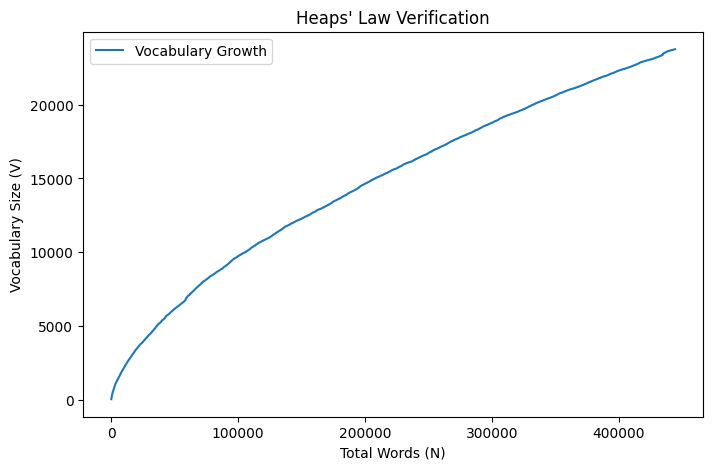

Estimated k: 8.528689399196075, Estimated beta: 0.6101018572066522


In [ ]:
# Tokenize all reviews
all_words = []
vocab_sizes = []
total_words = []

# Compute vocabulary size iteratively
for review in data['EnglishReview']:
    words = review.split()
    all_words.extend(words)
    vocab_sizes.append(len(set(all_words)))
    total_words.append(len(all_words))

# Plot Heaps' Law
plt.figure(figsize=(8, 5))
plt.plot(total_words, vocab_sizes, label="Vocabulary Growth")
plt.title("Heaps' Law Verification")
plt.xlabel("Total Words (N)")
plt.ylabel("Vocabulary Size (V)")
plt.legend()
plt.show()

# Optional: Fit a curve to find k and beta
from scipy.optimize import curve_fit

def heaps_law(N, k, beta):
    return k * N ** beta

params, _ = curve_fit(heaps_law, total_words, vocab_sizes)
print(f"Estimated k: {params[0]}, Estimated beta: {params[1]}")

## RAG system

### Loading data

In [ ]:
final_data = pd.read_csv("final_data.csv")

In [ ]:
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

In [ ]:
#Dataframe loader
loader = DataFrameLoader(final_data, page_content_column = 'Documents')  #Documents is used as content, while all other columns are added as metadata
documents = loader.load()

### Text Splitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 100,
    length_function = len
)

splitted_documents = text_splitter.transform_documents(documents)
print("The number of final documents is: ", len(splitted_documents))

The number of final documents is:  12941


## Embedding model
In the following block, we performed a series of operations to prepare and optimize an embedding model for sentence similarity evaluation

We tested three different embedding models provided by Hugging Face:
- [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)
- [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
- [bert-base-nli-mean-tokens](https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens)

Our choice fell on ```all-mpnet-base-v2```, as it was the one that brought the best results in the experiments we did.

The embedding model will be loaded with a cache to improve performance (it avoids re-computing embeddings for the same queries).

Finally, we will create an archive of vectors via [FAISS](https://github.com/facebookresearch/faiss/) on which we will perform similarity search.



In [ ]:
cache_path = LocalFileStore('./cache/')

# HuggingFace name of the desired model
model_id = 'sentence-transformers/all-MiniLM-L6-v2'

# Creation of the embedding given the selected model
embedding_model = HuggingFaceEmbeddings(model_name = model_id)

# Caching to avoid embedding the same queries multiple times
embedder = CacheBackedEmbeddings.from_bytes_store(embedding_model, cache_path, namespace = model_id)

# FAISS vector store of the reviews
vector_store = FAISS.from_documents(splitted_documents, embedder)


<ipython-input-27-2f1946b92051>:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name = model_id)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Retrieval without metadata filtering

In [ ]:
# here we perform a similarity search to get a glance of the performance of the embedder
query = 'I need to do a medical visit. Which apartment is closer to the hospital? I also need more rooms since I have children'

embedding_vector = embedding_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 10)

for idx, doc in enumerate(docs):
  print(f'Document n. {idx+1}\nContent: {doc.page_content}\nMetadata: {doc.metadata}\n')

Document n. 1
Content: Very nice and super equipped apartment with everything you need, quiet area near the hospital but also downtown, responsive host available, flexible check-in and check-out.. <br/>thank you and I'll see you soon
Metadata: {'url': 'https://www.airbnb.com/rooms/661509809677124306', 'name': 'OrangePlace | Centro, Ospedali, Università', 'address': 'Padova, Veneto, Italia', 'bathroomLabel': '1 bagno', 'bedroomLabel': '1 camera da letto', 'allowChildren': False, 'allowsEvents': False, 'allowsInfant': False, 'allowsPets': False, 'allowsSmoking': False, 'personCapacity': 2, 'isHostedBySuperhost': True, 'roomType': 'Intero alloggio: appartamento'}

Document n. 2
Content: Accommodation located a few steps from the hospital, in a quiet area with parking (great value added in this city!). Clean and well-equipped house. Friendly and accurate photos. Friendly and helpful host.
Metadata: {'url': 'https://www.airbnb.com/rooms/53340894', 'name': 'Appartamento "A un passo dall\'osp

## Retrieval with metadata filtering

In [ ]:
# The following code is adapted from the notebook by [Original Author Name]
# Repository: https://github.com/OriginalAuthor/OriginalRepo
# Notebook: https://github.com/OriginalAuthor/OriginalRepo/blob/main/notebook_name.ipynb

import json
from typing import Dict, List

from haystack import Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

from haystack import Document
from haystack.document_stores.faiss import FAISS
from haystack.embeddings import HuggingFaceEmbeddings
from haystack.utils import LocalFileStore
from haystack.nodes import CacheBackedEmbeddings

@component()
class QueryMetadataExtractor:

    def __init__(self):
        prompt = """
        You are part of an information system that processes users queries.
        Given a user query you extract information from it that matches a given list of metadata fields.
        The information to be extracted from the query must match the semantics associated with the given metadata fields.
        The information that you extracted from the query will then be used as filters to narrow down the search space
        when querying an index.
        Just include the value of the extracted metadata without including the name of the metadata field.
        The extracted information in 'Extracted metadata' must be returned as a valid JSON structure.
        ###
        Example 1:
        Query: "I would like to stay in a room in a shared apartment with private bathroom in Padua. I also have a dog, so pets should be allowed.
        What is the best accomodation for me?"
        Metadata fields: {"roomType", "bathroomLabel","allowsPets"}
        Extracted metadata fields: {"roomType": "private room in apartment", "bathroomLabel": "1 private bathroom", "allowsPets": True}
        ###
        Example 2:
        Query: "I am planning a trip near Padua. We're in 4 and we would like to have 2 bedrooms, since there are two children. Some of us also smoke, so it would be better to
        have a place where is it possible to do so. What is the best apartment suggested?"
        Metadata fields: {"personCapacity", "bedroomLabel","allowChildren", "allowsSmoking"}
        Extracted metadata fields: {"personCapacity": "4", "bedroomLabel": "2 bedrooms", "allowChildren": True, "allowsSmoking": True}
        ###
        Example 3:
        Query: "We are a family with a toddler. We would like to stay in an entire apartment with 2 bathrooms in the centre of Padua.
        I prefer apartments hosted by a superhost since I think they are more relialable. We would like to invite some friends for Christmas and do a small party in the house.
        Which is the best solution to our needs?"
        Metadata fields: {"roomType", "bathroomLabel", "isHostedBySuperhost", "allowsInfant", "allowsEvent"}
        Extracted metadata fields: {"roomType": "Entire accommodation: apartment", "bathroomLabel": "2 bathrooms", "isHostedBySuperhost": True,
        "allowsInfant": True,"allowsEvent": True}
        ###
        Example 4:
        Query: "{{query}}"
        Metadata fields: "{{metadata_fields}}"
        Extracted metadata fields:
        """
        self.pipeline = Pipeline()
        self.pipeline.add_component(name="builder", instance=PromptBuilder(prompt))
        self.pipeline.add_component(name="llm", instance=OpenAIGenerator(model="gpt-4o-mini"))
        self.pipeline.connect("builder", "llm")

    @component.output_types(filters=Dict[str, str])
    def run(self, query: str, metadata_fields: List[str]):
        result = self.pipeline.run({'builder': {'query': query, 'metadata_fields': metadata_fields}})
        metadata = json.loads(result['llm']['replies'][0])

        filters = []
        for key, value in metadata.items():
            field = f"meta.{key}"
            filters.append({"field": field, "operator": "==", "value": value})

        return {"filters": {"operator": "AND", "conditions": filters}}

In [ ]:
# Example metadata filtering function
def filter_documents_by_metadata(metadata_filters, documents):
    filtered_docs = []
    for doc in documents:
        match = True
        for key, value in metadata_filters.items():
            if key not in doc.meta or doc.meta[key] != value:
                match = False
                break
        if match:
            filtered_docs.append(doc)
    return filtered_docs

# Metadata fields extraction from query
query = "We need to stay in Padua for 3 days. We are a family of 5 people with 2 toddlers. We would like to have 2 bedrooms and we prefer to be close to the univerisity area in Portello. Which is the best accomodation for us?"
metadata_fields = {"personCapacity", "allowsInfant", "bedroomLabel"}

# Extract metadata from query
metadata_extractor = QueryMetadataExtractor()
metadata = metadata_extractor.run(query, list(metadata_fields))["filters"]["conditions"]
metadata_filters = {cond["field"].replace("meta.", ""): cond["value"] for cond in metadata}

# Now we filter the documents based on the extracted metadata
filtered_docs = filter_documents_by_metadata(metadata_filters, vector_store.get_all_documents())

# If there are any filtered documents, proceed to similarity search
if filtered_docs:
    embedding_vector = embedding_model.embed_query(query)
    filtered_vector_store = FAISS.from_documents(filtered_docs, embedder)
    docs = filtered_vector_store.similarity_search_by_vector(embedding_vector, k=10)

    for idx, doc in enumerate(docs):
        print(f'Document n. {idx+1}\nContent: {doc.page_content}\nMetadata: {doc.metadata}\n')
else:
    print("No documents found matching the metadata filters.")

### Text Splitter

In [ ]:
from huggingface_hub import notebook_login
token = "insert_your_token"
notebook_login()

In [ ]:
import torch
import transformers

model_id = "meta-llama/Llama-2-13b-chat-hf"

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_config = transformers.AutoConfig.from_pretrained(
    model_id
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)

model.eval()

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((5120,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((5120,), eps=

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id
)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    do_sample=True,
    temperature=0.2,
    max_new_tokens=256
)

Device set to use cuda:0


In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

<ipython-input-32-b18d252f13dc>:3: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=generate_text)


In [ ]:
from langchain_core.prompts.prompt import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.callbacks import StdOutCallbackHandler

In [ ]:
# prompt
template = (
    """
    <s>[INST]
    You are an assistant for question-answering tasks.
    The theme of the questions is: AirBnB reviews and house rules in Padua and province.
    Use the following pieces of retrieved context to answer the question.
    Feel free to ignore some context if it is not useful for the answer.
    If you don't know the answer, apologize and say you don't know.
    If there isn't any accomodation which is perfect with the needs of the client, you should suggest some alternatives,
    highlighting what are the things which do not correspond to the requested needs.
    Please ensure your responses are supported by the information from the retrieved documents.

    </s>
    [INST]
    Context: {context}
    [/INST]
    Question: {question}
    Helpful Answer:
    """
)

# this document template allows us to pass metadata to the model
# otherwise only page_content is used
document_prompt = PromptTemplate(
    input_variables = ['page_content', 'name', 'city', 'bathroomLabel', 'bedroomLabel', 'allowChildren', 'allowEvents', 'allowsInfant',
                       'allowsSmoking','personCapacity','isHostedBySuperhost','roomType'],
    template = """
        name: {name};
        city: {city};
        number of bathrooms: {bathroomLabel}
        number of bedrooms: {bedroomLabel};
        allows children: {allowChildren};
        allows events: {allowsEvents};
        allows infant: {allowsInfant};
        allows pets: {allowsPets};
        allows smoking: {allowsSmoking};
        person capacity: {personCapacity};
        is hosted by a superhost: {isHostedBySuperhost};
        room type: {roomType};
        review or house rule: {page_content}"""
)


In [ ]:
# retriever based on the vector store to perform sentence similarity searches
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs = {"k" : 5})

# callback for std out
stdout_handler = StdOutCallbackHandler()

# QA chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type = "stuff",
    retriever = retriever,
    callbacks=[stdout_handler],
    chain_type_kwargs = {
        "prompt": PromptTemplate(template=template, input_variables=[]),
        "document_prompt": document_prompt
    },
    return_source_documents=True
)

In [ ]:
qa({'query' : "I need to do a medical visit. Which apartment is closer to the hospital? I also need more rooms since I have children"})

<ipython-input-36-8474668595c7>:1: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  qa({'query' : "I need to do a medical visit. Which apartment is closer to the hospital? I also need more rooms since I have children"})




> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'I need to do a medical visit. Which apartment is closer to the hospital? I also need more rooms since I have children',
 'result': '\n    <s>[INST]\n    You are an assistant for question-answering tasks.\n    The theme of the questions is: AirBnB reviews and house rules in Padua and province.\n    Use the following pieces of retrieved context to answer the question.\n    Feel free to ignore some context if it is not useful for the answer.\n    If you don\'t know the answer, apologize and say you don\'t know.\n    Please ensure your responses are supported by the information from the retrieved documents.\n\n    </s>\n    [INST]\n    Context: \n        name: OrangePlace | Centro, Ospedali, Università;\n        city: Padua, Veneto, Italy;\n        number of bathrooms: 1 bathroom\n        number of bedrooms: 1 bedroom;\n        allows children: False;\n        allows events: False;\n        allows infant: False;\n        allows pets: False;\n        allows smoking: False;\n     